In [33]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [38]:
import pandas as pd
from pandas import DataFrame, Series
#adding graphics
import matplotlib.pyplot as plt
%pylab inline
from pylab import rcParams
from collections import defaultdict
from collections import OrderedDict as od
rcParams['figure.figsize'] = 18, 6

#from IPython.html import widgets 
import ipywidgets as widgets
from IPython.display import display

###################################

all_lic = pd.read_table('ontario_coord.csv', sep=',') 

#fix the dates
def addyear(x):
    ystr = x[6]+x[7]
    if (ystr>'18') :
        ystr = '19'+ystr
    else :
        ystr = '20'+ystr
    return ystr

def getarea(po) :
    area = po[:3]
    return area
# get rid of nulls in postal codes
all_lic= all_lic[pd.notnull(all_lic['Licence Address Line 3'])]
all_lic['year']=all_lic["Issued"].map(addyear)
all_lic['area']=all_lic['postal'].map(getarea)
#print all_lic
###############################
cat = all_lic['Category']
d = defaultdict(int)
for c in cat :   
    d[c]+=1
df = DataFrame(d.items(),columns=['category','count'])
indf = df.set_index(['category'])
indf=indf.sort_index()
#####################################
def limit_year(dataset,start=None,end=None,year=None) :
    target = dataset
    if (start is not None):
#        print " filtering for start year " + start
        target= target [target['year']>= start]
    if (end is not None) :
#        print " filtering for end year " + end
        target = target[target['year']<= end]
    if (year is not None) :
#        print " filtering for  year " + year
        target = target[target['year']== year]
    return target

# here we build the weights of each area
def getweighted(dataset) :
    target = dataset
    areadict = defaultdict(int)
    for c in dataset['area'] :   
        areadict[c]+=1
    f = lambda x : areadict[x]
    target['w'] = target['area'].map(f)
    return target

# function gets total of a category through years in a single dataset
def get_totals_by(dataset,cat) :
    d = defaultdict(int)
    catseries=dataset[cat]
    for c in catseries :   
        d[c]+=1
    df = DataFrame(d.items(),columns=[cat,'count'])
    indf = df.set_index([cat])
    indf= indf.sort_index()
    return indf

def limit_by_area (dataset,area) :
    target = dataset[dataset['area']==area]
    return target

def get_category(cat):
    cat_target= all_lic [all_lic['Category']==cat]
    return cat_target
################################################
year_rest = limit_year(get_category(cat='EATING ESTABLISHMENT'),year='2012')


year_w = getweighted(year_rest)

#ignore errors
year_w=year_w[year_w['lat']!=0]

year_w_heatdata= year_w[['lat','lng','w']]
heatmapdata= year_w_heatdata.to_records(index=False)


Populating the interactive namespace from numpy and matplotlib


ADULT ENTERTAINMENT CLUB
1980
2015
ALL
(123, 11)


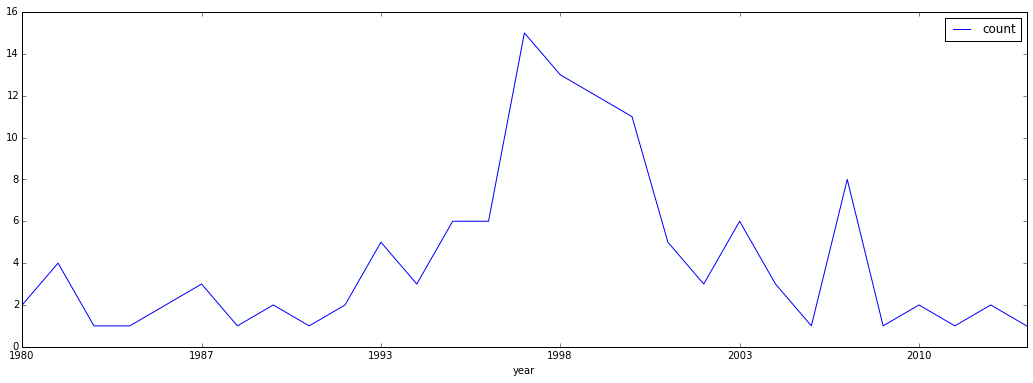

In [39]:
# Time to put an interface on this
def yearly_graph(category,starty,endy,postal,printme):
    print category
    print starty
    print endy
    print postal
    
    if postal=="ALL" :
        dataset = limit_year(get_category(cat=category),start=str(starty),end=str(endy))
#        print dataset
    else :
        dataset = limit_by_area(limit_year(get_category(cat=category),start=str(starty),end=str(endy)),postal)
    print dataset.shape
    totals = get_totals_by(dataset,'year')
    totals.plot()
    if (printme) :
        print dataset[['Licence No.','Operating Name','Issued']]

catlist_w = widgets.Select()
catlist_w.options = list( indf.index)
catlist_w.label =" Category "

yearrange= range(1980,2016)
stryearrange =[str(i) for i in yearrange]


startyear_w = widgets.IntSlider(value=1980,min=1919,max=2015,step=1,description='Start YEAR !')
endyear_w = widgets.IntSlider(value=2015,min=1919,max=2015,step=1,description='End YEAR !')



postalfield = widgets.Text()
postalfield.label = "Postal Code"
postalfield.description = "Postal Code"
postalfield.value ="ALL"

print_data_w = widgets.ToggleButton(
    description='Print Data',
    value=False
)

start_range = widgets.IntSlider(min=1980,max=2015,step=1,description='STart YEAR !')

i = widgets.interact( yearly_graph,
                 category    = catlist_w, 
                 starty  = startyear_w,
                 endy = endyear_w,
                 postal = postalfield,
                 printme = print_data_w
             )
